# Analyse PDF file


PDF "Portable Document Format" est un format de fichier utilisé pour constituer des documents contenant des images et du texte ainsi que des éléments tels que des liens cliquables vers des ressources sur des sites internet.
Il est constituté de 4 sections : 
- **Header** : contient le numéro de la version 
- **Body** : contient les objets (du type catalogue et les streams) et leurs valeurs 
- **Cross Reference Table** : 
- **Trailer** : 


Les données présentes dans le corps du document peuvent être altérées par rapport à leur format original. De nombreuses raisons peuvent l'expliquer : chiffrement, encodage, compression. Vous l'aurez compris ces méthodes peuvent également utilisées pour dissimuler du code malveillant. Il reste néanmoins plutôt facile d'identifier leur usage grâce à la présence du marqueur "/Filter" avant chacune des fonctions manipulant le contenu des données :  
- **/ASCII85Decode** : 
- **/ASCIIHexdecode** : 
- **/Crypt** : utilisé lorsque les données sont chiffrées. Une recherche de l'algorithme de chiffrement doit être réalisée lors de la présence de cette fonction.
- **/FlateDecode** : utilisé lorsque les données sont compressées via Zlib.
- **/LZWDecode** : utilisé lorsque les données sont compressées via l'algorithme LZW.


Cette première partie de l'analyse a pour objectif de charger les modules Python nécessaires à la bonne exécution du notebook. \
La variable **pdfFile** correspondant au chemin du fichier PDF à analyser devra être saisie. 

In [275]:
from colorama import init, Fore, Back, Style
import os
import json
import peepdf
from IPython import display

from msticpy.transform.iocextract import IoCExtract
import msticpy as mp
mp.init_notebook(globals(), verbosity=0)
ti = mp.TILookup()
ti.loaded_providers



pdfFile = "/home/secubian/Desktop/Cases/pdfs/61f0e80b2a74bf26d2089e09e779b0514b4d7e324de6f968bb224cbe6f2fab91.pdf"
pdfFile = "/home/secubian/Desktop/Cases/pdfs/1796aef0940e800bcb2556782f92a7874422bbdfdda24e6658e43db4b0916850.pdf"
pdfFile = "/home/secubian/Desktop/Cases/pdfs/0062742b752ac42b2812ee2670b18943322856268c8d3e23e7f97656bd41969e.pdf"
#pdfFile = "/home/secubian/Desktop/Cases/pdfs/907e75030b0e09cec6524f612f1c7439b5260b57b43d515968f81ba69278ba77.pdf"
#pdfFile = "/home/secubian/Desktop/Cases/pdfs/d1c2cc0ca653df8ddb46c1337a5972eaceb81ea924e8ebdb7af0699a7ab909fd.pdf"
#pdfFile = "/home/secubian/Desktop/Cases/pdfs/embedded_xls_180888bfe38fb7843583c469b893806ff0f9bb169c5e7be900779764742be229.pdf"


pdfFileReport = {}
pdfFileReport['version'] = []

pdf_parser = peepdf.PDFCore.PDFParser()
ret, pdf = pdf_parser.parse(pdfFile, True)

pdfFileReport['file'] = pdf.getStats().get('File',[])
pdfFileReport['md5'] = pdf.getStats().get('MD5',[])
pdfFileReport['sha256'] = pdf.getStats().get('SHA256',[])
pdfFileReport['detection'] = pdf.getStats().get('Detection',[])
pdfFileReport['pdf_version'] = pdf.getStats().get('Version',[])
if pdf.getStats().get('Binary',[]): pdfFileReport['binary'] = pdf.getStats().get('Binary',[])
if pdf.getStats().get('Encrypted',[]): pdfFileReport['encrypted'] = pdf.getStats().get('Encrypted',[])
if pdf.getStats().get('Encryption Algorithms',[]): pdfFileReport['encryption_algorithm'] = pdf.getStats().get('Encryption Algorithms',[])
if pdf.getStats().get('Comments',[]): pdfFileReport['comments'] = pdf.getStats().get('Comments',[])

pdfFileReport['pdfFile_version_count'] = len(pdf.getStats().get("Versions",[]))

for version in pdf.getStats().get("Versions",[]):
    pdfVersion = {}
    if version.get("Actions", []):  pdfVersion['actions'] = version.get("Actions", [])
    if version.get("Compressed Objects", []): pdfVersion['compressed_objects'] = version.get("Compressed Objects", [])
    if version.get("Encoded", []): pdfVersion['encoded_objects'] = version.get("Encoded", [])
    if version.get("Elements", []): pdfVersion['elements'] = version.get("Elements", [])
    if version.get("Events", []): pdfVersion['events'] = version.get("Events", [])
    if version.get("Objects with JS code", []): pdfVersion['objects_with_js'] = version.get("Objects with JS code", [])
    if version.get("Streams", []): pdfVersion['streams'] = version.get("Streams", [])
    if pdf.getURIs(): pdfVersion['URI'] = pdf.getURIs()
    if pdf.getURLs(): pdfVersion['URL'] = pdf.getURLs()
    if version.get("Vulns", []): pdfVersion['vulns'] = version.get("Vulns", [])

    pdfFileReport['version'].append(pdfVersion)

#pdf.getStats()

## Méta Données

La toute première étape consiste à obtenir les méta-données du fichier PDF. \
Ces dernières vont nous permettre d'interroger les bonnes de Threat Intel, afin d'identifier rapidement tout ficher malveillant.

In [276]:
if (pdfFileReport):
    print(Fore.GREEN + "[!] PDF file analyse success")
    print(f"File Name : {pdfFileReport['file']}")
    print(f"Comments : {pdfFileReport['comments']}")
    print(f"PDF version : {pdfFileReport['pdf_version']}")
    print(f"File Hash [md5] : {pdfFileReport['md5']}")
    print(f"File Hash [sha256] : {pdfFileReport['sha256']}")
else:
    print(Fore.RED + "[✓] PDF file analyse failed.")


[!] PDF file analyse success
File Name : 0062742b752ac42b2812ee2670b18943322856268c8d3e23e7f97656bd41969e.pdf
Comments : 0
PDF version : 1.3
File Hash [md5] : e4bfb0cd8422d9cf5d43335b1d5395ec
File Hash [sha256] : 0062742b752ac42b2812ee2670b18943322856268c8d3e23e7f97656bd41969e


## Recherche en Threat Intel des hashs identifiés.

In [278]:
df_ti = ti.lookup_iocs(data=[pdfFileReport['md5'], pdfFileReport['sha256']], providers=["VirusTotal", "OTX"])
#df_ti = df_ti[df_ti['Result']==True]
df_ti = pd.json_normalize(data=df_ti[['Ioc','Provider','Details']].to_dict(orient='records'))

if (df_ti.empty):
    print(Fore.GREEN + "[✓] No Potentially identified as malicious")
else:
    print(Fore.RED + "[!] Potentially identified as malicious")
    display(df_ti)


Observables processed:   0%|          | 0/4 [00:00<?, ?obs/s]

[!] Potentially identified as malicious


,Ioc,Provider,Details.pulse_count,Details.sections_available,Details
0,e4bfb0cd8422d9cf5d43335b1d5395ec,OTX,0.0,"[general, analysis]",NaN
1,0062742b752ac42b2812ee2670b18943322856268c8d3e23e7f97656bd41969e,OTX,0.0,"[general, analysis]",NaN
2,e4bfb0cd8422d9cf5d43335b1d5395ec,VirusTotal,NaN,NaN,Request forbidden. Allowed query rate may have been exceeded.
3,0062742b752ac42b2812ee2670b18943322856268c8d3e23e7f97656bd41969e,VirusTotal,NaN,NaN,Request forbidden. Allowed query rate may have been exceeded.


## Analyse des sections du document PDF 



Les sections les plus interessantes sont les suivantes : 
- **EmbeddedFile** : Cette section énumère les fichiers présents au sein du fichier PDF. Il peut s'agir par exemple de script ou d'image.
- **Javascript** ou **JS** : Il s'agit d'une référence à du Javascript pouvant être exécuté à l'ouverture du fichier PDF.
- **Names** : Noms des éventuels fichiers auxquels le fichier PDF pourrait faire référence.
- **OpenAction** ou **Launch** : Il s'agit d'une fonction exécutée à l'ouverture du fichier pdf. Elle peut être utilisée pour exécuter un script par exemple.
- **URI** ou **SubmitForm** : Cette section recense les éventuelles références à des URL pouvant conduire le lecteur du fichier PDF à télécharger des scripts/binaires malveillants.



Maintenant que nous avons présenté les sections potentiellement suspectes. \
Ces dernières vont être extraites via l'outil **peepdf**, afin de compléter l'analyse.

### Identification de code Javascript

In [169]:
artefact_js = []
for version in pdf.getStats().get("Versions",[]):
    if version.get("Objects with JS code", []): 
        artefact_js.append(version.get("Objects with JS code", []))

if artefact_js:
    print(Fore.RED + "[✓] Some Javascript code detected")
    print(artefact_js)
else:
    print(Fore.GREEN + "[!] No Javascript code detected")

[!] No Javascript code detected


### Identification des sections OpenAction/Launch

In [170]:
artefact_openaction = []
for version in pdf.getStats().get("Versions",[]):
    if version.get("Actions", []):  
        artefact_openaction.append(version.get("Actions", []))
    if version.get("Events", []):  
        artefact_openaction.append(version.get("Events", []))

if artefact_openaction:
    print(Fore.RED + "[✓] Some OpenAction/Launch detected")
    print(artefact_openaction)
else:
    print(Fore.GREEN + "[!] No OpenAction/Launch detected")


[!] No OpenAction/Launch detected


### Identification des URI/URL

In [184]:
artefact_uri = []
for version in pdf.getStats().get("Versions",[]):
    if pdf.getURIs(): 
        for uri in pdf.getURIs():
            if uri: artefact_uri.append(uri[0])
    if pdf.getURLs(): 
        for url in pdf.getURLs():
            if url: artefact_uri.append(url[0])

artefact_uri = set(artefact_uri)
if (artefact_uri):
    print(Fore.RED + "[✓] Some URI/URL detected")
    print(artefact_uri)
else:
    print(Fore.GREEN + "[!] No URI/URL detected")


[✓] Some URI/URL detected
{'https://rheumatoidarthritis.xyz/QU-26469592.exe'}


### Identification des éventuelles vulnérabilités

In [185]:
artefact_vulns = []
for version in pdf.getStats().get("Versions",[]):
    if version.get("Vulns", []):  
        artefact_openaction.append(version.get("Vulns", []))


if (artefact_vulns):
    print(Fore.RED + "[✓] Some vulnerabilities detected")
    print(artefact_vulns)
else:
    print(Fore.GREEN + "[!] No vulnerabilities detected")


[!] No vulnerabilities detected


### Identification de fichier(s) présent(s) dans le PDF

Cette analyse permet de mettre en avant de potentiel(s) fichier(s) malveillant(s) caché(s) au sein du fichier pdf.

In [186]:
artefact_embedded = []
for version in pdf.getStats().get("Versions",[]):
    if version.get("Elements", []):  
        artefact_embedded.append(version.get("Elements", []))


if (artefact_embedded):
    print(Fore.RED + "[✓] Some embedded files detected")
    print(artefact_embedded)
else:
    print(Fore.GREEN + "[!] No embedded files detected")

[!] No embedded files detected


Il est tout à fait possible d'extraire les documents incrustés via la commande **pdf-parser**.

In [187]:
objectID = 82
os.system(f"pdf-parser.py --object {objectID} -f -w -d {pdfFile}_{objectID} {pdfFile} 1>/dev/null 2>&1")

0

Le type de fichier extrait, peut désormais être identifié via la commande **file**.

In [218]:
os.system(f"file {pdfFile}_{objectID}")

/home/secubian/Desktop/Cases/pdfs/0062742b752ac42b2812ee2670b18943322856268c8d3e23e7f97656bd41969e.pdf_7: cannot open `/home/secubian/Desktop/Cases/pdfs/0062742b752ac42b2812ee2670b18943322856268c8d3e23e7f97656bd41969e.pdf_7' (No such file or directory)


0

### Analyse avancée des objets

Dans un second temps, nous allons identifier si le contenu est chiffré, encodé ou toutes autres sections suspectes.

In [188]:
artefact_encoded = []
artefact_compressed = []

for version in pdf.getStats().get("Versions",[]):
    if version.get("Compressed Objects", []): artefact_compressed.append(version.get("Compressed Objects", []))
    if version.get("Encoded", []): artefact_encoded.append(version.get("Encoded", []))

if artefact_encoded:
    print(Fore.RED + "[✓] Some encoded section detected.")
    print(artefact_encoded)

if artefact_compressed:
    print(Fore.RED + "[✓] Some compressed objects detected. Result contains stream ID.")
    print(artefact_compressed)


[✓] Some encoded section detected.
[['6', [3, 4, 6, 7, 13, 14]], ['0', []]]


Certains objets ont été identifiés comme encodé ou chiffré. \
Il peut être interessant de réaliser une analyse approfondie en visualisant le contenu de ces objets. \
Pour cela, vous devrez saisir la valeur **objectID**.

In [197]:
# Advanced Analyse about objects
# Encoded object : 1, 2, 4
## source : https://github.com/jesparza/peepdf/blob/master/peepdf.py
objectID = 7
object = pdf.getObject(objectID)

objectReport = {}
objectReport['type'] = object.elements['/Type'].getValue()
objectReport['length'] = object.elements['/Length'].getValue()
objectReport['filter'] = object.elements['/Filter'].getValue()
print(objectReport)
object.getRawValue()



{'type': '/XObject', 'length': '245', 'filter': '[ /ASCII85Decode /FlateDecode ]'}


'<< /BitsPerComponent 8\n/ColorSpace /DeviceGray\n/Decode [ 0 1 ]\n/Filter [ /ASCII85Decode /FlateDecode ]\n/Height 51\n/Length 245\n/Subtype /Image\n/Type /XObject\n/Width 204 >>\nstream\n  /Subtype /Image /Type /XObject /Width 204\n>>\nstream\nGb"0TYmnQ(\'SPEm=YfRL2N:ifBjl`QGTVT:fFgjX%7pX&$O2,/SRUD6_>bu$5*:]XFD6!DeEtn6.j)qUh=Ih!<A$!8\\jSnq?FNmRb&kjLMF0mIEFR8X"t^W1cj>$,#BYNgR*c(`nf;#/B=>!,&J5Te&J5Te&J5W*jbaPp1RueqH?)a[Pr8Lb=7j8B&<C_Ui^KY38*FXD4/ErY6c7cFe^]!Fq_@gc_q>UMM!k)hQsqJU^*hp^-S5~>\nendstream'

Si le contenu est compressé ou encodé, l'outil pdf-parser peut être util pour traiter l'information et obtenir un rendu favorisant l'analyse.

In [214]:
objectID = 7
os.system(f"pdf-parser.py --object {objectID} -f  {pdfFile} ")

obj 7 0
 Type: /XObject
 Referencing: 
 Contains stream

  <<
    /BitsPerComponent 8
    /ColorSpace /DeviceGray
    /Decode [ 0 1 ]
    /Filter [ /ASCII85Decode /FlateDecode ]
    /Height 51
    /Length 245
    /Subtype /Image
    /Type /XObject
    /Width 204
  >>

 '\x00\x00\x00\x00\x00\x06V\xa6\xdf\xf9\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff

0

## Analyse visuelle du document

Si l'analyse statique n'a rien révelé, il peut être interessant d'analyser l'aspect visuel du document. \
Plutôt que de l'ouvrir avec un logiciel dédié, il est préférable de générer une image du contenu afin de limiter les risques de contamination. 

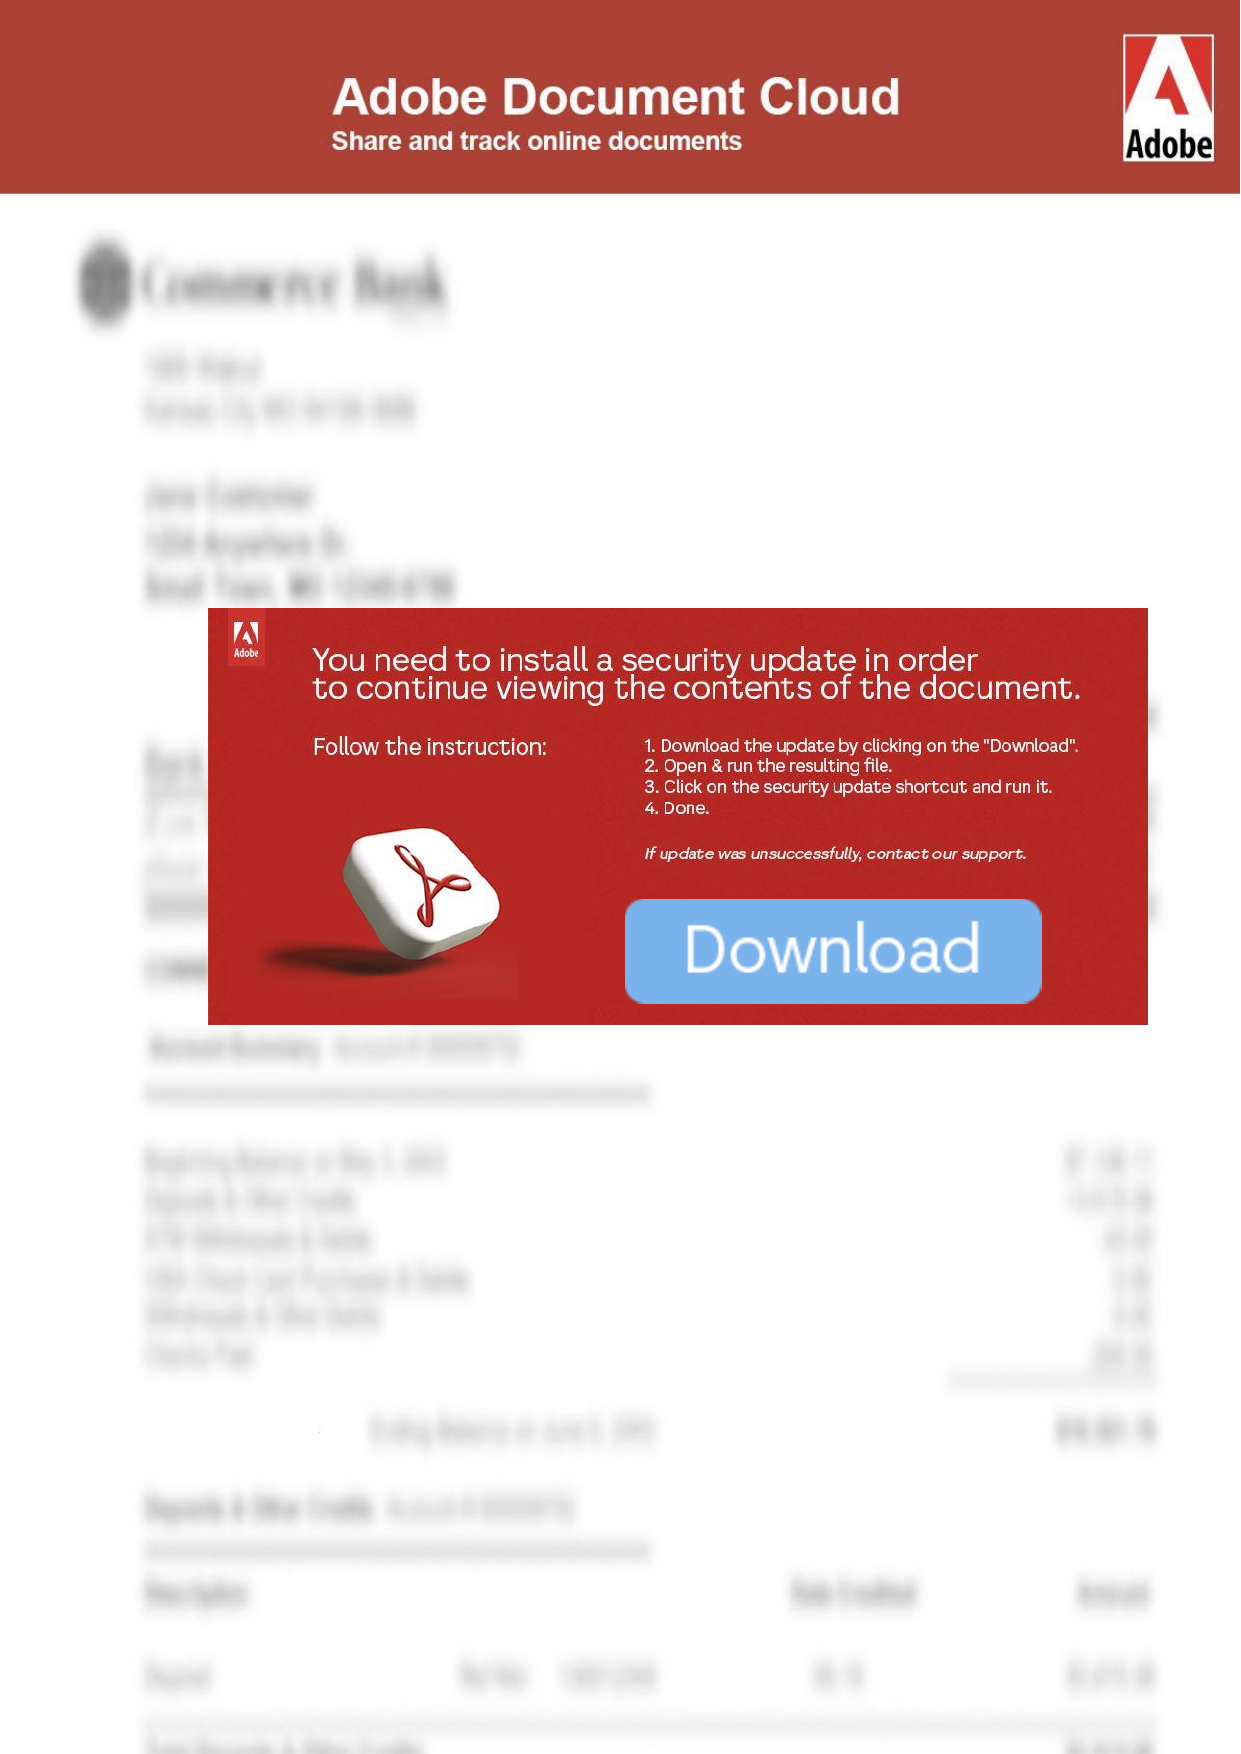

In [204]:
os.system(f"pdftoppm {pdfFile} {pdfFile} -png -singlefile")
display.Image(f"{pdfFile}.png")

Pour rédiger ce notebook, je me suis inspiré des scripts ci-dessous : 
- https://raw.githubusercontent.com/intelowlproject/IntelOwl/master/api_app/analyzers_manager/file_analyzers/pdf_info.py
- https://github.com/hiddenillusion/AnalyzePDF/blob/master/AnalyzePDF.py
- https://prtksec.github.io/posts/MA_PDF_Notes/